# Plotting the CTH Results

In [1]:
%pylab inline
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.ticker as mtick
from hits import CyDetHits, CTHHits, CDCHits

## Import Data

In [3]:
# Test on signal or background data files
test_sig = True

In [4]:
if test_sig:
    hits_cydet = CyDetHits('../data/151209_signal_tracks.root', signal_coding=[1], hit_type_name="tid",
                           branches=["x", "y"])
    hits_cth = CTHHits('../data/151209_signal_tracks.root', signal_coding=[1], hit_type_name="tid",
                       branches=["x", "y"])
else:
    hits_cydet = CyDetHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])
    hits_cth = CTHHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])

In [5]:
hits = CDCHits(hits_cydet, hits_cth)

from cylinder import CyDet
geom = CyDet()
n_events = hits_cth.n_events
print "Start Events: {}".format(hits.cth.n_events)

Start Events: 79587


## Apply All Cuts

In [6]:
# Define cuts to use
n_hits_cut = False
layer_cut = False
timing_cut = False
use_cth_cut = True

In [7]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)
    hits.cth.trim_hits(variable=hits.cth.time_name, less_than=1100, greater_than=700)
    hits.cydet.trim_hits(variable=hits.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)

In [8]:
# Filter for CTH in time window.  Get the time
trigger_events = []
for evt in range(hits.n_events):
    sig_hits = hits.cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        trigger_events.append(evt)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

Events that pass CTH Trigger: 22091


In [9]:
# Filter for max layer is five
max_layer = []
for evt in range(hits.n_events):
    these_layers = hits.cydet.geom.point_layers[hits.cydet.get_sig_wires(evt)]
    if len(hits.cydet.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "Number that pass layer cut: {}".format(len(good_max_layer))

Number that pass layer cut: 42646


In [10]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(hits.cydet.get_signal_hits(evt)) 
                         for evt in range(hits.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits > 30)[0]
print "Number that pass n hits cut: {}".format(len(good_n_hits))

Number that pass n hits cut: 45145


In [11]:
# Apply quality and CTH cuts
print "Start Events: {}".format(hits.n_events)
if use_cth_cut:
    hits.trim_events(trigger_events)
    print "After CTH Trigger {}".format(hits.n_events)
if layer_cut:
    hits.trim_events(good_max_layer)
    print "After Layer Cut Trigger {}".format(hits.n_events)
if n_hits_cut:
    hits.trim_events(good_events)
    print "Afterb N Hits Cut Trigger {}".format(hits.n_events)

Start Events: 79587
After CTH Trigger 22091


In [12]:
print hits.cth.all_branches

['M_x', 'M_y', 'M_tid', 'M_nHits', 'M_hits_index', 'M_event_index', 'M_vol_id', 'M_edep', 'M_t', 'M_mt', 'M_position']


## Experiment to get the correct geometric parameters

In [13]:
from cylinder import CTH, CylindricalArray

In [14]:
n_crystals = 64
# The first two rows are for the active volumes, third is for excluded
# volumes
cth_n_vols = [n_crystals, n_crystals, n_crystals]
cth_radii = [44.8, 48.3, 0.0]
cth_phi0 = [-np.pi/2., -np.pi/2., -np.pi/2.]
test_geom = CylindricalArray(cth_n_vols, cth_radii, cth_phi0)

In [21]:
widths = [1, 0.5]
heights = [9, 9]
deflection_angles = [16.5, 10]
all_vols_shown = [range(64), range(64,128)]
print_me = False
evt = 1

### Plot the All CTH Hits From All Events

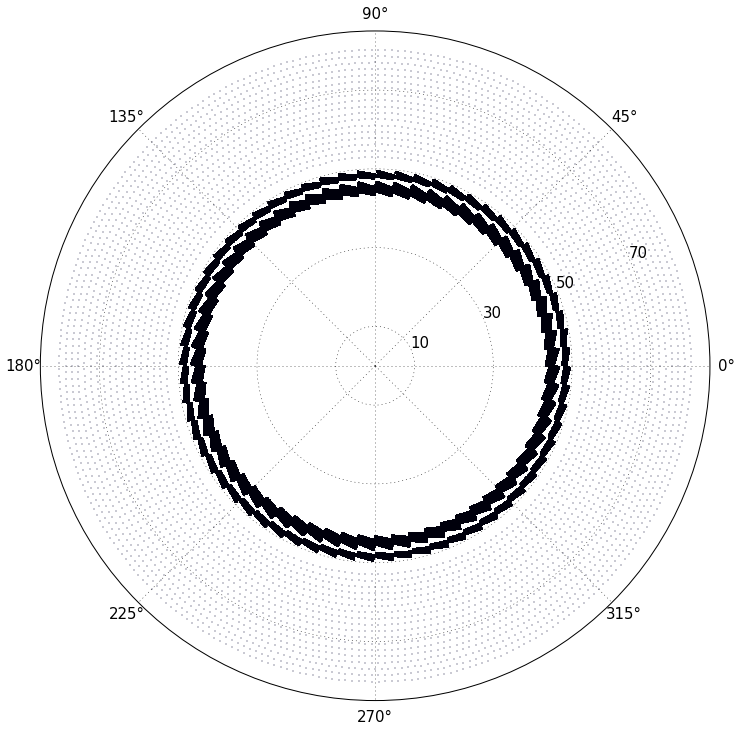

In [22]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(np.zeros(hits.cydet.geom.n_points), geom)
cth_hits = hits.cth.get_hit_vols(evt)

# Get all hit points in first volumev
vol_hits = hits.cth.filter_hits(hits.cth.down_data, "M_vol_id", values=range(128))
plt.scatter(vol_hits["M_x"], vol_hits["M_y"], s=1, transform=gca().transData._b)    

### Ensure Drawn Volumes Overlap With Hits

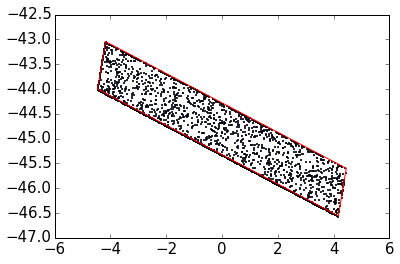

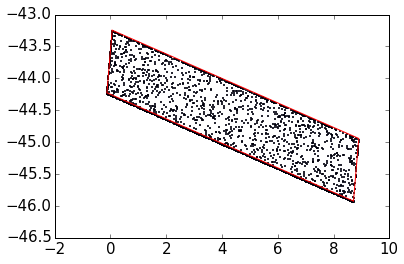

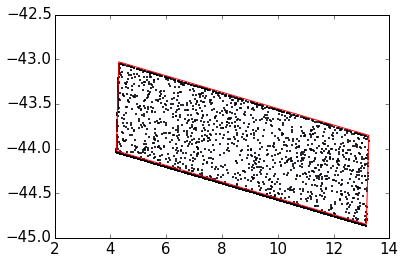

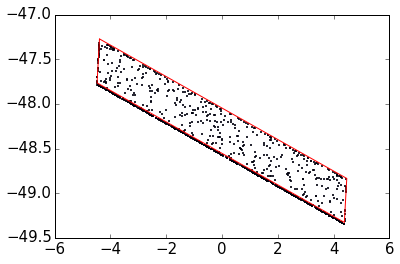

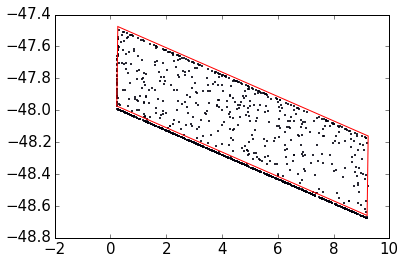

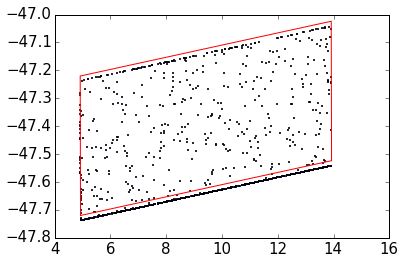

In [23]:
for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):
    for vol in vols_shown[:3]: 
        x = test_geom.point_x[vol]
        y = test_geom.point_y[vol]

        theta_rotate = np.arctan((y)/(x)) - deflection*np.pi/180.
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        this_vol = hits.cth.filter_hits(vol_hits, "M_vol_id", values=vol)

        plt.scatter(this_vol["M_x"], this_vol["M_y"], s=1, transform=gca().transData._b)
        plot_angle = (theta_rotate/np.pi) * 180.
        plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                    color="red", fill=False)
        gca().add_artist(plot_rect)
        plt.show()

### Draw Volumes over Hits

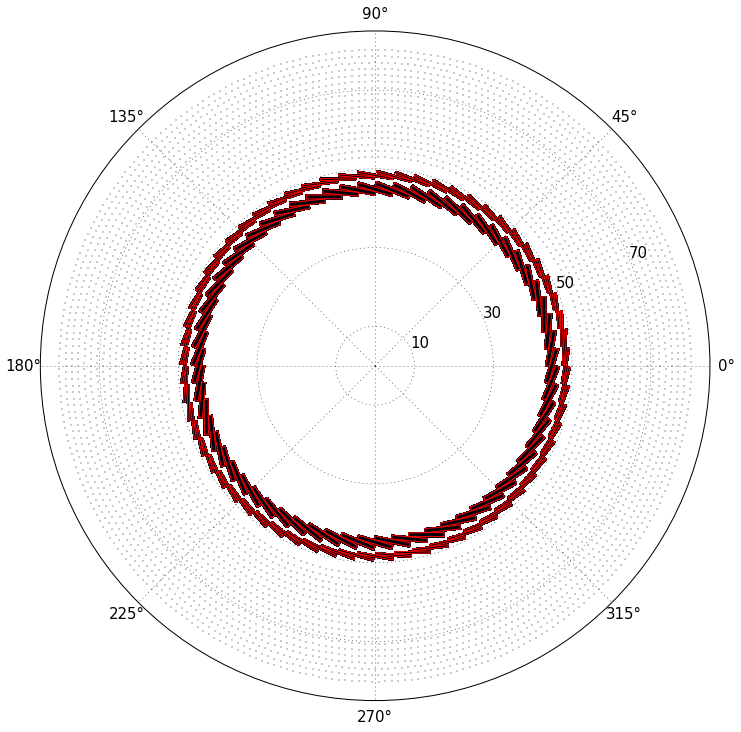

In [24]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(np.zeros(hits.cydet.geom.n_points), geom)
cth_hits = hits.cth.get_hit_vols(evt)

# Get all hit points in first volumev
vol_hits = hits.cth.filter_hits(hits.cth.down_data, "M_vol_id", values=range(128))
plt.scatter(vol_hits["M_x"], vol_hits["M_y"], s=1, transform=gca().transData._b)    

for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):

    for vol, x, y in zip(vols_shown, test_geom.point_x[vols_shown],test_geom.point_y[vols_shown]): 

        theta_rotate = np.arctan((y)/(x)) - deflection*np.pi/180
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        # Truth information
        this_vol = hits.cth.filter_hits(vol_hits, "M_vol_id", values=vol)

        if print_me:
            # Range
            #x_true = (max(this_vol["M_x"]) - min(this_vol["M_x"]))
            #y_true = (max(this_vol["M_y"]) - min(this_vol["M_y"]))
            # Average
            x_true = average(this_vol["M_x"])
            y_true = average(this_vol["M_y"])
            print "index " + str(vol)
            print "  x " + str(test_geom.point_x[vol])
            #print "  x_plt " + str(x_plt)
            print "  x_true " + str(x_true)
            print "  y " + str(test_geom.point_y[vol])
            #print "  y_plt " + str(y_plt)
            print "  y_true " + str(y_true)
            print y_true - y 
            print x_true - x
            print sqrt(x_true**2 + y_true**2)

        plot_angle = (theta_rotate/np.pi) * 180.

        plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                  transform=gca().transData._b, fill=False, color="red")
           #     color="green", fill=False, alpha=l_alpha, lw=lw)
        gca().add_artist(plot_rect)

### Draw Volumes with no Hits

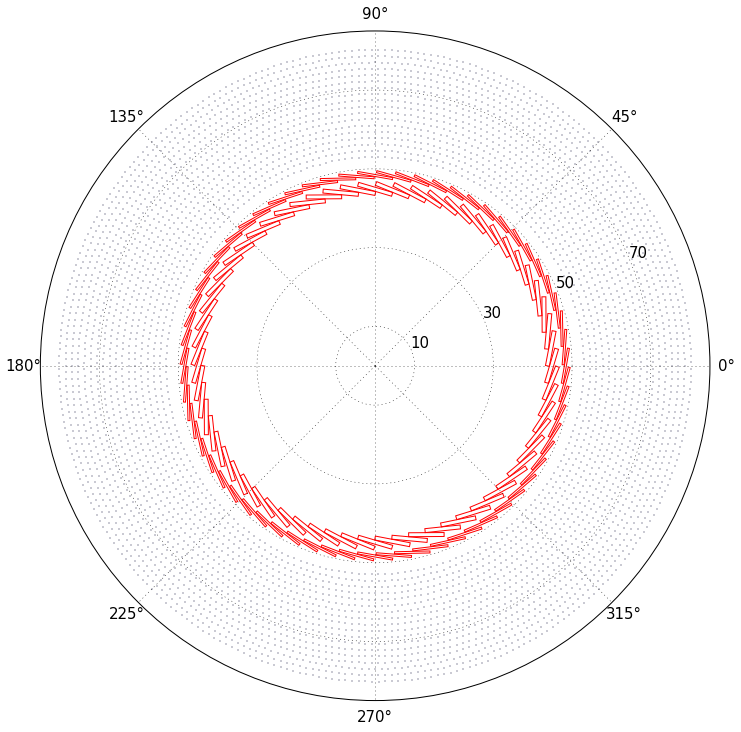

In [25]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(np.zeros(hits.cydet.geom.n_points), geom)
cth_hits = hits.cth.get_hit_vols(evt)

for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):

    for vol, x, y in zip(vols_shown, test_geom.point_x[vols_shown],test_geom.point_y[vols_shown]): 

        theta_rotate = np.arctan((y)/(x)) - deflection*np.pi/180
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        # Truth information
        this_vol = hits.cth.filter_hits(vol_hits, "M_vol_id", values=vol)

        if print_me:
            # Range
            #x_true = (max(this_vol["M_x"]) - min(this_vol["M_x"]))
            #y_true = (max(this_vol["M_y"]) - min(this_vol["M_y"]))
            # Average
            x_true = average(this_vol["M_x"])
            y_true = average(this_vol["M_y"])
            print "index " + str(vol)
            print "  x " + str(test_geom.point_x[vol])
            #print "  x_plt " + str(x_plt)
            print "  x_true " + str(x_true)
            print "  y " + str(test_geom.point_y[vol])
            #print "  y_plt " + str(y_plt)
            print "  y_true " + str(y_true)
            print y_true - y 
            print x_true - x
            print sqrt(x_true**2 + y_true**2)

        plot_angle = (theta_rotate/np.pi) * 180.

        plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                  transform=gca().transData._b, fill=False, color="red")
           #     color="green", fill=False, alpha=l_alpha, lw=lw)
        gca().add_artist(plot_rect)

## Drawing the Hit Volumes

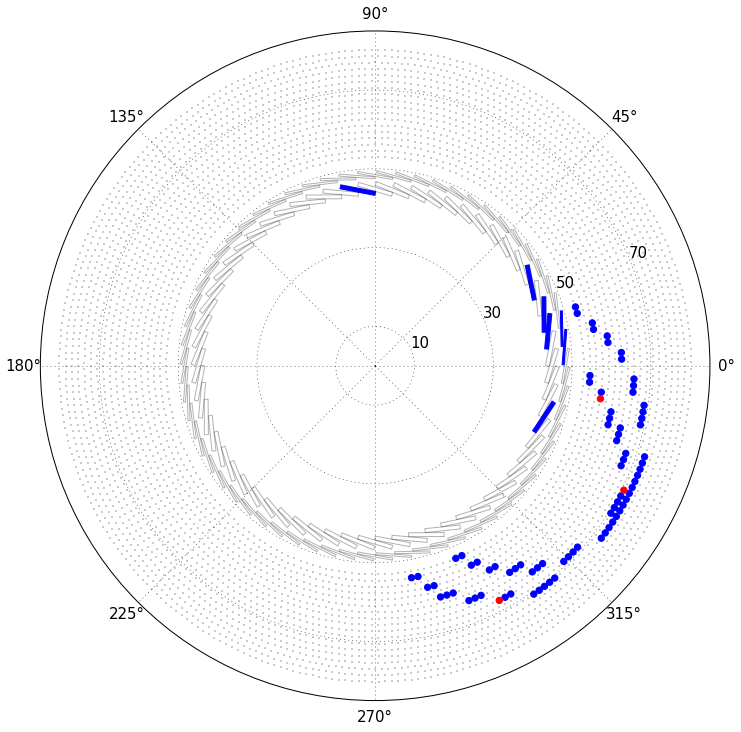

In [26]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(all_hits, geom)
cth_hits = hits.cth.get_hit_vols(evt)

# Get all hit points in first volumev
these_vols_shown = hits.cth.get_hit_vols(events=evt)

for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):

    for vol, x, y in zip(vols_shown, test_geom.point_x[vols_shown],test_geom.point_y[vols_shown]): 
        theta_rotate = np.arctan((y)/(x)) - deflection*np.pi/180
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        # Truth information
        this_vol = hits.cth.filter_hits(vol_hits, "M_vol_id", values=vol)

        if print_me:
            # Range
            #x_true = (max(this_vol["M_x"]) - min(this_vol["M_x"]))
            #y_true = (max(this_vol["M_y"]) - min(this_vol["M_y"]))
            # Average
            x_true = average(this_vol["M_x"])
            y_true = average(this_vol["M_y"])
            print "index " + str(vol)
            print "  x " + str(test_geom.point_x[vol])
            #print "  x_plt " + str(x_plt)
            print "  x_true " + str(x_true)
            print "  y " + str(test_geom.point_y[vol])
            #print "  y_plt " + str(y_plt)
            print "  y_true " + str(y_true)
            print y_true - y 
            print x_true - x
            print sqrt(x_true**2 + y_true**2)

        plot_angle = (theta_rotate/np.pi) * 180.
        if vol in these_vols_shown:
            plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                      transform=gca().transData._b, color="blue")
               #     color="green", fill=False, alpha=l_alpha, lw=lw)
        else: 
            plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                      transform=gca().transData._b, fill=False, lw=1, alpha=0.3,
                                      color="black")
        gca().add_artist(plot_rect)  